<a href="https://colab.research.google.com/github/ayushabhinav/FlowerClassification/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install kaggle

In [26]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"ayushabhinav","key":"3ddcd48ba3efb72c6b4444109fbe531c"}'}

In [27]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alxmamaev/flowers-recognition
! ls -lrt

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
total 230156
drwxr-xr-x 1 root root      4096 Sep 16 13:40  sample_data
-rw-r--r-- 1 root root        68 Oct  1 10:42  kaggle.json
-rw-r--r-- 1 root root 235663188 Oct  1 10:42  flowers-recognition.zip
drwxr-xr-x 7 root root      4096 Oct  1 10:42  flowers
-rw-r--r-- 1 root root        68 Oct  1 12:31 'kaggle (1).json'


In [28]:
!unzip -q flowers-recognition.zip
! ls -lrt flowers

replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
total 248
drwxr-xr-x 2 root root 40960 Oct  1 12:31 daisy
drwxr-xr-x 2 root root 65536 Oct  1 12:31 dandelion
drwxr-xr-x 2 root root 40960 Oct  1 12:31 rose
drwxr-xr-x 2 root root 36864 Oct  1 12:31 sunflower
drwxr-xr-x 2 root root 65536 Oct  1 12:31 tulip


In [29]:
# imports

import os
import glob
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
#setting up folder paths
dataset_path = os.path.join(os.getcwd(), 'flowers')

In [31]:
#count of images in each class
flower_type_count = pd.DataFrame( [[c, len(os.listdir(os.path.join(dataset_path, c)))] for c in os.listdir(dataset_path)], columns=['name', 'count'])
flower_type_count

,name,count
0,sunflower,733
1,dandelion,1052
2,rose,784
3,tulip,984
4,daisy,764


In [32]:
def plot_images(images, title):
  fig, axes = plt.subplots(1, len(images))
  fig.set_figwidth(10)
  for ax, img in zip(axes, images):
    ax.imshow(img)
    ax.axis('off')
  plt.suptitle(c, fontsize=20, fontweight='bold')
  plt.show()

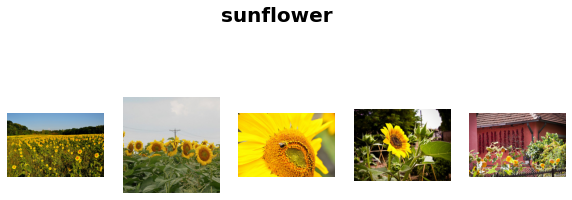

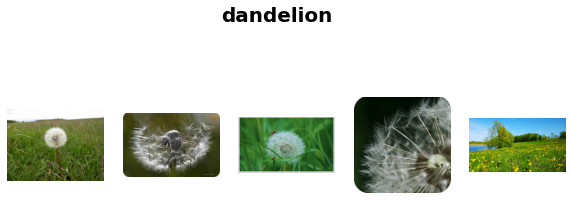

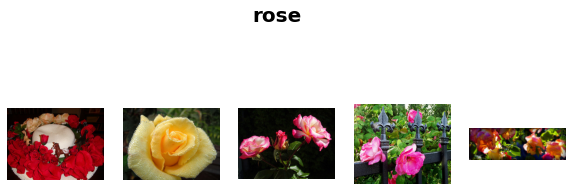

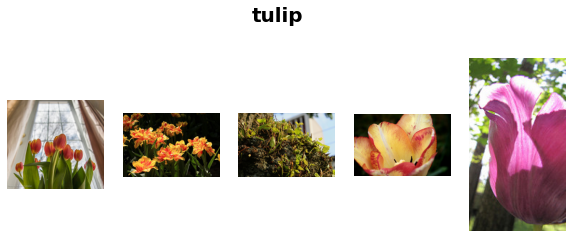

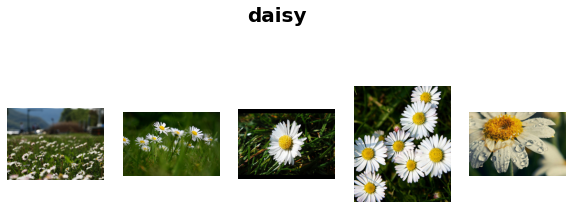

In [33]:
# visualizing some flowers from each class
for c in os.listdir(dataset_path):
  cpath = os.path.join(dataset_path, c)
  image_files = [random.choice(os.listdir(cpath))for i in range(5)]
  images = [plt.imread(os.path.join(cpath, image_file)) for image_file in image_files]
  plot_images(images, title=c)
  print()
    

### Custom Data Generator

In [45]:
import tensorflow as tf
from tensorflow import keras

In [193]:
class MyDataGenerator(keras.utils.Sequence):

  def __init__(self, dataset_path, mode='train', validation_perc=None, ablation=None, target_cls=None,
               batch_size=32, dim=(256, 256), preprocessing_fn=None, n_channel=3, shuffle=True):
    
    self.batch_size = batch_size
    self.preprocessing_fn = preprocessing_fn
    self.n_channel = n_channel
    self.shuffle = shuffle
    self.dim = dim
    self.labels = {}
    self.image_ID = []

    if target_cls is None:
      self.target_cls = os.listdir(dataset_path)
    else:
      self.target_cls = target_cls

    self.n_classes = len(self.target_cls)


    for i, cls in enumerate(self.target_cls):
      paths = glob.glob(os.path.join(dataset_path, cls, '*'))
      
      brk_point = len(paths)
      if validation_perc is not None:
        brk_point = int(len(paths) * (1- validation_perc))
      
      if mode == 'train':
        paths = paths[:brk_point]
      else:
        paths = paths[brk_point:]

      if ablation is not None:
        abl_point = int(len(paths) * ablation)
        paths = paths[:abl_point]

      self.image_ID += paths
      self.labels.update({img:i for img in paths})

    self.on_epoch_end()



  def on_epoch_end(self):
    self.indices = np.arange(len(self.image_ID))
    if self.shuffle:
      np.random.shuffle(self.indices)
      
  def __len__(self):
    return int(np.floor(len(self.image_ID)/self.batch_size ))


  def __iter__(self):
    for item in ( self.__getitem__(i) for i in range(len(self))):
      yield item

  def __getitem__(self, index):
    print(index)
    print(index * self.batch_size , (index +1) * self.batch_size)
    indexes = self.indices[ index * self.batch_size : (index +1) * self.batch_size ]
    ids = [ self.image_ID[idx] for idx in indexes]
    X, y = self._generate_data(ids)
    print(y.shape)
    return X, y

  def _generate_data(self, ids):

    X = np.empty((self.batch_size, *self.dim, self.n_channel))
    y = np.empty((self.batch_size), dtype=np.int)

    for idx , id in enumerate(ids):
      img = plt.imread(id)
      img = np.resize(img, (*self.dim, self.n_channel))
      # print(f' image shape :{img.shape}')
      if self.preprocessing_fn is not None:
        img = self.preprocessing_fn(img)
        # print(f'processed image shape : f{img.shape}')
      X[idx] = img
      y[idx] = self.labels[id]

    y = keras.utils.to_categorical(y, self.n_classes)
      
    return X, y


In [194]:
train_datagen = MyDataGenerator(dataset_path, target_cls=['rose', 'daisy'], validation_perc=.2, ablation=0.1, mode='train', dim=(224, 224), preprocessing_fn=keras.applications.resnet50.preprocess_input)
valid_datagen = MyDataGenerator(dataset_path, target_cls=['rose', 'daisy'], validation_perc=.2, mode='validation', dim=(224, 224), preprocessing_fn=keras.applications.resnet50.preprocess_input)

In [197]:
for d in train_datagen:
  print(d[0].shape)

0
0 32
(32, 2)
(32, 224, 224, 3)
1
32 64
(32, 2)
(32, 224, 224, 3)
2
64 96
(32, 2)
(32, 224, 224, 3)


### Model Building 

In [157]:

import tensorflow as tf
from tensorflow import keras

In [160]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
)

In [198]:
# building the model

inputs = keras.layers.Input(shape=[224, 224, 3])
X = base_model(inputs, training=False)
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(512, activation='relu')(X)
X = keras.layers.Dense(128, activation='relu')(X)
outputs = keras.layers.Dense(1, activation='softmax')(X)

model = keras.Model(inputs, outputs)


In [199]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [202]:
history = model.fit(train_datagen, epochs=10)

0
0 32
(32, 2)
Epoch 1/10
2
64 96
(32, 2)
1
32 64
(32, 2)


InvalidArgumentError: ignored